In [1]:
# Importaciones de librerías estándar
import ast

# Importaciones de librerías para análisis de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importaciones de librerías para procesamiento y modelado
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Importaciones de librerías de aprendizaje profundo y NLP
from sentence_transformers import SentenceTransformer

# Importaciones de modelos y encoders
import xgboost as xgb
import category_encoders as ce

# Importación para guardar y cargar modelos
import joblib

/home/updavo/APPS/master/tada-picking/venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
df_taylor = pd.read_csv("./ai_models/data/Taylor_Train.csv", encoding = "ISO-8859-1")
df_artists = pd.read_csv("./ai_models/data/Artists.csv", encoding = "ISO-8859-1")

In [4]:
df_taylor.head(4)

,City,Country,Venue,Opening act(s),Attendance (tickets sold / available),Revenue,Tour
0,Evansville,United States,Roberts Municipal Stadium,Gloriana\r\nKellie Pickler,"7,463 / 7,463","$360,617",Fearless_Tour
1,Jonesboro,United States,Convocation Center,Gloriana\r\nKellie Pickler,"7,822 / 7,822","$340,328",Fearless_Tour
2,St. Louis,United States,Scottrade Center,Gloriana\r\nKellie Pickler,"13,764 / 13,764","$650,420",Fearless_Tour
3,Alexandria,United States,Bishop Ireton High School,Gloriana\r\nKellie Pickler,,,Fearless_Tour


In [5]:
df_artists.head(4)

,Name,ID,Gender,Age,Country,Genres,Popularity,Followers,URI
0,Drake,3TVXtAsR1Inumwj472S9r4,male,33,CA,"['canadian hip hop', 'canadian pop', 'hip hop'...",95,83298497,spotify:artist:3TVXtAsR1Inumwj472S9r4
1,Post Malone,246dkjvS1zLTtiykXe5h60,male,25,US,"['dfw rap', 'melodic rap', 'pop', 'rap']",86,43130108,spotify:artist:246dkjvS1zLTtiykXe5h60
2,Ed Sheeran,6eUKZXaKkcviH0Ku9w2n3V,male,29,GB,"['pop', 'singer-songwriter pop', 'uk pop']",87,115998928,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V
3,J Balvin,1vyhD5VmyZ7KMfW5gqLgo5,male,35,CO,"['reggaeton', 'reggaeton colombiano', 'trap la...",83,38028010,spotify:artist:1vyhD5VmyZ7KMfW5gqLgo5


# Revenue and tickets

In [7]:
df_original = df_taylor.copy()

# Seperate tickets sold and tickets available
df_taylor[["Tickets sold", "Tickets available"]] = df_taylor["Attendance (tickets sold / available)"].str.split("/", expand = True)
df_taylor = df_taylor.drop("Attendance (tickets sold / available)", axis = 1)

# Drop $ sign in revenue
df_taylor['Revenue'] = df_taylor['Revenue'].str.replace('$', '')

# Remove comma in revenue, tickets sold and tickets available
df_taylor['Revenue'] = df_taylor['Revenue'].str.replace(',', '')
df_taylor['Tickets sold'] = df_taylor['Tickets sold'].str.replace(',', '')
df_taylor['Tickets available'] = df_taylor['Tickets available'].str.replace(',', '')

In [8]:
# Change data types
df_taylor['Revenue'] = pd.to_numeric(df_taylor['Revenue'], errors='coerce')
df_taylor['Tickets sold'] = pd.to_numeric(df_taylor['Tickets sold'], errors='coerce')
df_taylor['Tickets available'] = pd.to_numeric(df_taylor['Tickets available'], errors='coerce')

df_taylor['Number of opening acts'] = df_taylor['Opening act(s)'].apply(lambda x: 0 if 'No' in str(x) else 1 if 'and' not in str(x) else x.count('and') + 1)
df_taylor.head()

# mean imputation
df_taylor['Revenue'].fillna(df_taylor['Revenue'].mean(), inplace = True)
df_taylor['Tickets sold'].fillna(df_taylor['Tickets sold'].mean(), inplace = True)
df_taylor['Tickets available'].fillna(df_taylor['Tickets available'].mean(), inplace = True)
df_taylor['Tickets remaining'] = df_taylor['Tickets available'] - df_taylor['Tickets sold']

/tmp/ipykernel_30064/1048178157.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_taylor['Revenue'].fillna(df_taylor['Revenue'].mean(), inplace = True)
/tmp/ipykernel_30064/1048178157.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [9]:
df_taylor = df_taylor.drop(['Opening act(s)', 'Tour', 'Tickets remaining', 'Tickets available', 'Number of opening acts'], axis=1)
df_taylor['Popularity'] = 100

In [10]:
df_taylor.head(4)

,City,Country,Venue,Revenue,Tickets sold,Popularity
0,Evansville,United States,Roberts Municipal Stadium,3.606170e+05,7463.000000,100
1,Jonesboro,United States,Convocation Center,3.403280e+05,7822.000000,100
2,St. Louis,United States,Scottrade Center,6.504200e+05,13764.000000,100
3,Alexandria,United States,Bishop Ireton High School,3.892357e+06,38954.904177,100


In [134]:
# Crear la estructura anidada
result = []

# Agrupar por país
for country_name, country_group in df_taylor.groupby('Country'):
    country_dict = {
        'country': country_name,
        'cities': []
    }

    # Agrupar por ciudad dentro del país
    for city_name, city_group in country_group.groupby('City'):
        city_dict = {
            'city': city_name,
            'venues': city_group['Venue'].unique().tolist()
        }
        country_dict['cities'].append(city_dict)

    result.append(country_dict)

In [136]:
print(result)

[{'country': 'Australia', 'cities': [{'city': 'Adelaide', 'venues': ['Adelaide Entertainment Centre']}, {'city': 'Brisbane', 'venues': ['Brisbane Entertainment Centre', 'Suncorp Stadium', 'The Gabba']}, {'city': 'Melbourne', 'venues': ['Rod Laver Arena', 'Etihad Stadium', 'AAMI Park', 'Marvel Stadium']}, {'city': 'Newcastle', 'venues': ['Newcastle Entertainment Centre']}, {'city': 'Perth', 'venues': ['Burswood Dome', 'Perth Rectangular Stadium', 'Optus Stadium']}, {'city': 'Sydney', 'venues': ['Acer Arena', 'Allphones Arena', 'Allianz Stadium', 'ANZ Stadium']}]}, {'country': 'Belgium', 'cities': [{'city': 'Brussels', 'venues': ['Forest National']}]}, {'country': 'Canada', 'cities': [{'city': 'Calgary', 'venues': ['Pengrowth Saddledome']}, {'city': 'Cavendish', 'venues': ['Cavendish Beach Festival Grounds']}, {'city': 'Craven', 'venues': ['Big Valley Park']}, {'city': 'Edmonton', 'venues': ['Commonwealth Stadium', 'Rexall Place']}, {'city': 'Montreal', 'venues': ['Bell Centre']}, {'city

In [112]:
df_taylor.head(4)

,City,Country,Venue,Revenue,Tickets sold,Popularity
0,Evansville,United States,Roberts Municipal Stadium,3.606170e+05,7463.000000,100
1,Jonesboro,United States,Convocation Center,3.403280e+05,7822.000000,100
2,St. Louis,United States,Scottrade Center,6.504200e+05,13764.000000,100
3,Alexandria,United States,Bishop Ireton High School,3.892357e+06,38954.904177,100


In [113]:
X = df_taylor[['City', 'Country', 'Venue', 'Popularity']]
y_revenue = df_taylor['Revenue']
y_tickets = df_taylor['Tickets sold']

In [116]:
pipeline_rev = Pipeline([
    ('encoder', ce.HashingEncoder(cols=['City', 'Country', 'Venue'], n_components=8)),
    ('model', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        eval_metric='rmse',
        random_state=42
    ))
])

In [117]:
pipeline_tic = Pipeline([
    ('encoder', ce.HashingEncoder(cols=['City', 'Country', 'Venue'], n_components=8)),
    ('model', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        eval_metric='rmse',
        random_state=42
    ))
])

In [118]:
# Para Revenue
X_train_rev, X_test_rev, y_train_rev, y_test_rev = train_test_split(
    X, y_revenue, test_size=0.2, random_state=42
)

# Para Tickets sold
X_train_tic, X_test_tic, y_train_tic, y_test_tic = train_test_split(
    X, y_tickets, test_size=0.2, random_state=42
)

In [119]:
# Para Revenue
pipeline_rev.fit(X_train_rev, y_train_rev)

# Para Tickets sold
pipeline_tic.fit(X_train_tic, y_train_tic)

Pipeline(steps=[('encoder',
                 HashingEncoder(cols=['City', 'Country', 'Venue'],
                                max_process=1, max_sample=356)),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [120]:
# Para Revenue
y_pred_rev = pipeline_rev.predict(X_test_rev)
rmse_rev = mean_squared_error(y_test_rev, y_pred_rev, squared=False)
print(f'RMSE para Revenue: {rmse_rev}')

# Para Tickets sold
y_pred_tic = pipeline_tic.predict(X_test_tic)
rmse_tic = mean_squared_error(y_test_tic, y_pred_tic, squared=False)
print(f'RMSE para Tickets sold: {rmse_tic}')

RMSE para Revenue: 4014591.5588565893


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE para Tickets sold: 31458.22954012796


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [121]:
joblib.dump(pipeline_rev, 'rev/pipeline_rev.pkl')
joblib.dump(pipeline_tic, 'rev/pipeline_tic.pkl')

['rev/pipeline_tic.pkl']

# Artists Model

In [11]:
df_artists = df_artists.drop(['ID', 'URI', 'Name'], axis=1)

In [12]:
df_artists.head(4)

,Gender,Age,Country,Genres,Popularity,Followers
0,male,33,CA,"['canadian hip hop', 'canadian pop', 'hip hop'...",95,83298497
1,male,25,US,"['dfw rap', 'melodic rap', 'pop', 'rap']",86,43130108
2,male,29,GB,"['pop', 'singer-songwriter pop', 'uk pop']",87,115998928
3,male,35,CO,"['reggaeton', 'reggaeton colombiano', 'trap la...",83,38028010


In [77]:
# Paso 1: Convertir los strings en listas de géneros
df_artists['Genres'] = df_artists['Genres'].apply(lambda x: ast.literal_eval(x))

# Paso 2: Normalizar los géneros
df_artists['Genres'] = df_artists['Genres'].apply(lambda x: list(set([genre.strip().lower() for genre in x])))

In [78]:
model_all_mini = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [79]:
# Paso 4: Generar los embeddings
def get_embeddings(genre_list):
    if len(genre_list) == 0:
        return np.zeros(384)  # Si no hay géneros, devolver un vector de ceros del tamaño correcto
    else:
        embeddings = model_all_mini.encode(genre_list)
        return np.mean(embeddings, axis=0)

df_artists['Genres_embeddings'] = df_artists['Genres'].apply(get_embeddings)

In [80]:
# Paso 5: Verificar que todos los embeddings tengan el tamaño correcto (384)
df_artists['embedding_size'] = df_artists['Genres_embeddings'].apply(lambda x: len(x))
df_artists_filtered = df_artists[df_artists['embedding_size'] == 384]

In [81]:
# Paso 6: Crear la matriz de embeddings y aplicar KMeans
embeddings_matrix = np.vstack(df_artists_filtered['Genres_embeddings'].values).astype(np.float32)

In [82]:
distortions = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings_matrix)
    distortions.append(kmeans.inertia_)

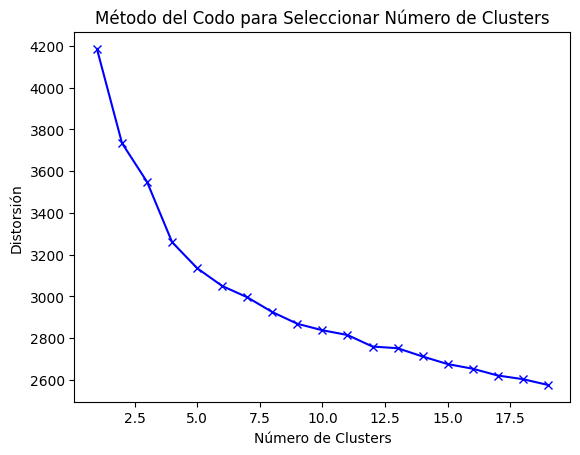

In [83]:
# Graficar el método del codo
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Distorsión')
plt.title('Método del Codo para Seleccionar Número de Clusters')
plt.show()

In [84]:
num_clusters = 13
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
df_artists_filtered['Genre_clusters'] = kmeans.fit_predict(embeddings_matrix)

In [85]:
joblib.dump(kmeans, 'art/kmeans_model.pkl')

['art/kmeans_model.pkl']

In [86]:
df_artists_filtered = df_artists_filtered.drop(['Genres', 'Genres_embeddings', 'embedding_size'], axis=1)

In [87]:
df_artists_filtered.head(6)

,Gender,Age,Country,Popularity,Followers,Genre_clusters
0,male,33,CA,95,83298497,12
1,male,25,US,86,43130108,12
2,male,29,GB,87,115998928,4
3,male,35,CO,83,38028010,0
4,male,26,PR,95,77931484,0
5,male,26,CA,88,75112165,4


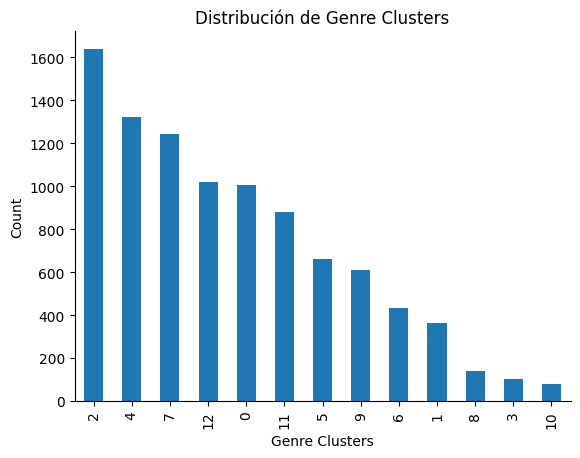

In [88]:
# Contar cuántos elementos hay en cada clúster
cluster_counts = df_artists_filtered['Genre_clusters'].value_counts().sort_values(ascending=False)
# Crear el gráfico de barras para mostrar los clústeres de mayor a menor
cluster_counts.plot(kind='bar', title='Distribución de Genre Clusters')
# Eliminar los bordes superiores y derechos del gráfico para que sea más limpio
plt.gca().spines[['top', 'right']].set_visible(False)
# Etiquetas para los ejes
plt.xlabel('Genre Clusters')
plt.ylabel('Count')
# Mostrar el gráfico
plt.show()

In [89]:
df_train_artist = df_artists_filtered.copy(deep=True)

In [90]:
# Codificar las variables categóricas (Gender y Country)
label_encoder_gender = LabelEncoder()
label_encoder_country = LabelEncoder()

df_train_artist['Gender_encoded'] = label_encoder_gender.fit_transform(df_train_artist['Gender'])
df_train_artist['Country_encoded'] = label_encoder_country.fit_transform(df_train_artist['Country'])

In [91]:
# Variables predictoras (features) y la variable objetivo (target)
X = df_train_artist[['Gender_encoded', 'Age', 'Country_encoded', 'Followers', 'Genre_clusters']]
y = df_train_artist['Popularity']

In [92]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
xgboost_model_authors = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

In [94]:
xgboost_model_authors.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Hacer predicciones en el conjunto de prueba
y_pred = xgboost_model_authors.predict(X_test)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Raíz del MSE

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 6.8316981158718795
MSE: 85.35391028740494
RMSE: 9.238718000210037


In [96]:
# Guardar los encoders en un archivo
joblib.dump({'gender_encoder': label_encoder_gender, 'country_encoder': label_encoder_country}, 'art/encoders.pkl')

print("Encoders guardados en 'encoders.pkl'")

Encoders guardados en 'encoders.pkl'


In [97]:
# Guardar el modelo XGBoost entrenado
joblib.dump(xgboost_model_authors, 'art/xgboost_model.pkl')

print("Modelo XGBoost guardado en 'xgboost_model.pkl'")

Modelo XGBoost guardado en 'xgboost_model.pkl'


# Carga de encoders y procesamiento de datos

## Resultados de artista

In [98]:
# Cargar el modelo XGBoost guardado
kmeans_loaded = joblib.load('art/kmeans_model.pkl')

print("Kmeans cargado.")

Kmeans cargado.


In [99]:
# Cargar los encoders guardados
encoders = joblib.load('art/encoders.pkl')
label_encoder_gender = encoders['gender_encoder']
label_encoder_country = encoders['country_encoder']

print("Encoders cargados.")

Encoders cargados.


In [100]:
# Cargar el modelo XGBoost guardado
xgboost_model = joblib.load('art/xgboost_model.pkl')

print("Modelo XGBoost cargado.")

Modelo XGBoost cargado.


In [101]:
# Cargar el modelo SentenceTransformer
model_all_mini = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [185]:
#Ejemplo real con morat

new_data = pd.DataFrame({
    'Gender': ['male'],
    'Age': [25],
    'Country': ['MX'],
    'Followers': [4200000],
    'Genres': [['reggaeton', 'pop', 'regueton latino', 'urbana', 'romance', 'amor']]
})

In [186]:
new_data

,Gender,Age,Country,Followers,Genres
0,male,25,MX,4200000,"[reggaeton, pop, regueton latino, urbana, roma..."


In [188]:
# Paso 1: Convertir los strings en listas de géneros
df_artists['Genres'] = df_artists['Genres'].apply(lambda x: list(set([genre.strip().lower() for genre in x])))

# Paso 2: Generar embeddings para los géneros nuevos
def get_embeddings(genre_list):
    if len(genre_list) == 0:
        return np.zeros(384, dtype=np.float32)  # Si no hay géneros, devolver un vector de ceros (float32)
    else:
        embeddings = model_all_mini.encode(genre_list)
        return np.mean(embeddings, axis=0).astype(np.float32)  # Asegurarse de que los embeddings sean float32

new_data['Genres_embeddings'] = new_data['Genres'].apply(get_embeddings)

# Paso 3: Convertir los embeddings a una matriz (asegurarse de que sean float32)
new_embeddings_matrix = np.vstack(new_data['Genres_embeddings'].values).astype(np.float32)

# Paso 4: Predecir el clúster usando el modelo KMeans cargado
predicted_cluster = kmeans_loaded.predict(new_embeddings_matrix)

# Paso 5: Asignar el clúster predicho a una nueva columna 'Genre_clusters'
new_data['Genre_clusters'] = predicted_cluster

# Eliminar la columna temporal 'Genres_embeddings'
new_data = new_data.drop(columns=['Genres','Genres_embeddings'], axis=1)

In [189]:
new_data

,Gender,Age,Country,Followers,Genre_clusters
0,male,25,MX,4200000,7


In [190]:
# Función para transformar nuevos valores con LabelEncoder, manejando valores no vistos
def safe_transform(encoder, value, default_value=-1):
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        print(f"Valor no visto: {value}. Asignando valor predeterminado {default_value}.")
        return default_value

# Aplicar los encoders a los nuevos datos, manejando valores no vistos
new_data['Gender_encoded'] = new_data['Gender'].apply(lambda x: safe_transform(label_encoder_gender, x))
new_data['Country_encoded'] = new_data['Country'].apply(lambda x: safe_transform(label_encoder_country, x))

# Preparar los datos de entrada
X_new = new_data[['Gender_encoded', 'Age', 'Country_encoded', 'Followers', 'Genre_clusters']]

# Hacer la predicción
popularity_prediction = xgboost_model.predict(X_new)

# new_data = pd.DataFrame({
#     'Gender': ['male'],
#     'Age': [25],
#     'Country': ['MX'],
#     'Followers': [4200000],
#     'Genres': [['reggaeton', 'pop', 'regueton latino', 'urbana', 'romance', 'amor']]
# })

print(f'Predicción de Popularidad: {int(round(popularity_prediction[0], 0))} / 100')

Predicción de Popularidad: 69 / 100


## Resultados de revenue y tickets

In [191]:
pipeline_rev_loaded = joblib.load('rev/pipeline_rev.pkl')

print("pipeline_rev cargado.")

pipeline_rev cargado.


In [192]:
pipeline_tic_loaded = joblib.load('rev/pipeline_tic.pkl')

print("pipeline_tic cargado.")

pipeline_tic cargado.


In [198]:
nueva_entrada = pd.DataFrame({
    'City': ['United States'],
    'Country': ['Evansville'],
    'Venue': ['Roberts Municipal Stadium'],
    'Popularity': [int(round(popularity_prediction[0], 0))]
})

#Evansville	United States	Roberts Municipal Stadium

In [199]:
nueva_entrada

,City,Country,Venue,Popularity
0,United States,Evansville,Roberts Municipal Stadium,69


In [200]:
# Predecir Revenue
prediccion_rev = pipeline_rev_loaded.predict(nueva_entrada)
print(f'Predicción de Revenue: {int(round(prediccion_rev[0],2))} USD')

Predicción de Revenue: 2289347 USD


In [201]:
# Predecir Tickets sold
prediccion_tic = pipeline_tic_loaded.predict(nueva_entrada)
print(f'Predicción de Tickets a vender: {int(round(prediccion_tic[0],2))}')

Predicción de Tickets a vender: 26248


In [202]:
# Calcular el precio por ticket
price_per_ticket = int(round(prediccion_rev[0],2)) / int(round(prediccion_tic[0],2))

# Mostrar el resultado con dos decimales
print(f"El precio por ticket promedio debe de ser: {price_per_ticket:.2f} USD")

El precio por ticket promedio debe de ser: 87.22 USD
